# MNIST Multi Digit Classification

In order to get familiar with the multi digit classification task, I first worked on classifying sequences of MNIST numbers. The MNIST dataset is often used as a toy dataset: the images it contains are rather centered and without much noise, which makes the classification much more easier than using real images.

In a second notebook I tackled the same problem on the much noiser Street View House Number dataset.

## 1. Creation of the multi-digit number MNIST dataset

In this part I used MNIST images to create a new dataset consisting on images of size 28x140 representing multi-digit numbers of length up to 5. To do so, I picked random images from the MNIST dataset and concatenated them.

In [2]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import os
from six.moves.urllib.request import urlretrieve
import tarfile
import sys
import scipy.io as sio
%matplotlib inline

We first extract the MNIST dataset from the Tensorflow tutorial's datasets:

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Then we create a dataset of 55 000 28x150 images concatenating MNIST images. Each image contains a number between 0 and 99999.

In [4]:
empty = np.zeros((28, 28), dtype = np.float32)
empty_label = np.eye(11)[10,:]
possible_elements = [5, 4, 3, 2, 1]

concatenated_images = []
concatenated_labels = []
concatenated_lengths = []
total_elements = 0
elements_count = -1
while(total_elements != 55000):
    labels_added = 1
    elements_count = (elements_count + 1)%5
    no_elements = possible_elements[elements_count]
    
    if(total_elements>54995 and total_elements + no_elements > 55000):
        break
    batch = mnist.train.next_batch(no_elements)
    image = np.split(batch[0][0], 28)
    label = [np.append(batch[1][0],0.)]
    for digit in range(1, no_elements):
        image = np.hstack((image, np.split(batch[0][digit], 28)))
        label.append(np.append(batch[1][digit],0.).tolist())
        labels_added += 1
    for digit in range(5-no_elements):
        image = np.hstack((image, empty))
        label.append(empty_label)
        
    length = np.zeros(5)
    length[labels_added-1] = 1.0
    
    concatenated_images.append(image)
    concatenated_labels.append(label)
    concatenated_lengths.append(length)
    total_elements += no_elements

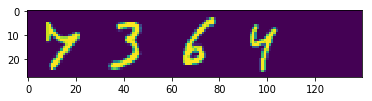

In [5]:
# An example of created image
plt.imshow(concatenated_images[11])

Now we save the images, labels and length in pickle files:

In [ ]:
set_images_filename = 'images.pickle'
set_labels_filename = 'labels.pickle'
set_lengths_filename = 'lengths.pickle'
def maybe_pickle(set_filename, data):
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)

maybe_pickle(set_images_filename, concatenated_images)
maybe_pickle(set_labels_filename, concatenated_labels)
maybe_pickle(set_lengths_filename, concatenated_lengths)

## 2. Data Preprocessing

In this section we first load the data, split it into train and test datasets, and finally reformat it.

In [6]:
pickle_file = ['images.pickle', 'labels.pickle', 'lengths.pickle']

with open(pickle_file[0], 'rb') as f:
    dataset = pickle.load(f)

with open(pickle_file[1], 'rb') as f:
    labels = pickle.load(f)

with open(pickle_file[2], 'rb') as f:
    lengths = pickle.load(f)

In [7]:
# We take 90% of the data for training and 10% for testing
split = int(len(dataset)*0.9)

train_dataset = np.asarray(dataset[:split]) 
test_dataset = np.asarray(dataset[split:])
train_labels = np.squeeze(np.asarray(labels[:split])) 
test_labels = np.squeeze(np.asarray(labels[split:]))
train_lengths = np.asarray(lengths)[:split,:]
test_lengths = np.asarray(lengths)[split:,:]

print('Training set', train_dataset.shape, train_labels.shape, train_lengths.shape)
print('Test set', test_dataset.shape, test_labels.shape, test_lengths.shape)

Training set (16498, 28, 140) (16498, 5, 11) (16498, 5)
Test set (1834, 28, 140) (1834, 5, 11) (1834, 5)


In [8]:
#We add the unique channel as a 4th dimension

image_size = 28
num_channels = 1 # grayscale

def reformat_dataset(dataset):
    dataset = dataset.reshape(
    (-1, image_size, image_size*5, num_channels)).astype(np.float32)
    return dataset

train_dataset = reformat_dataset(train_dataset)
test_dataset = reformat_dataset(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape, train_lengths.shape)
print('Test set', test_dataset.shape, test_labels.shape, test_lengths.shape)

Training set (16498, 28, 140, 1) (16498, 5, 11) (16498, 5)
Test set (1834, 28, 140, 1) (1834, 5, 11) (1834, 5)


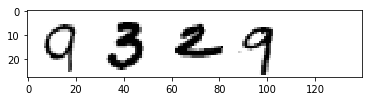

In [9]:
plt.imshow(train_dataset[126,:,:,:].reshape((28,140)), cmap='binary')

## 3. Model Training

Now we train a Deep CNN to classify these images:

In [10]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [12]:
batch_size = 64
patch_size = 5
depth = 64
num_hidden = 128
image_size = 28

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size*5, num_channels))
    tf_train_lengths = tf.placeholder(tf.float32, shape=(batch_size, 5))
    tf_train_labels1 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_train_labels2 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_train_labels3 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_train_labels4 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_train_labels5 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.get_variable('layer1',
      [patch_size, patch_size, num_channels, depth], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.get_variable('layer2',
      [patch_size, patch_size, depth, depth], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.get_variable('layer3',
      [1152, num_hidden], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.get_variable('layer4',
      [num_hidden, 5], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[5]))
    layer5_weights = tf.get_variable('layer5',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer6_weights = tf.get_variable('layer6',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer6_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer7_weights = tf.get_variable('layer7',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer7_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer8_weights = tf.get_variable('layer8',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer8_biases = tf.Variable(tf.constant(1.0, shape=[11]))
    layer9_weights = tf.get_variable('layer9',
      [num_hidden, 11], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer9_biases = tf.Variable(tf.constant(1.0, shape=[11]))
  
    # Model.
    def model(data, layer_weights, layer_biases):
        
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
        
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
        
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer_weights) + layer_biases
  
    # Training computation.
    logits1 = model(tf_train_dataset, layer4_weights, layer4_biases)
    loss1 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_lengths, logits=logits1))
    
    logits2 = model(tf_train_dataset, layer5_weights, layer5_biases)
    loss2 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels1, logits=logits2))
    
    logits3 = model(tf_train_dataset, layer6_weights, layer6_biases)
    loss3 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels2, logits=logits3))
    
    logits4 = model(tf_train_dataset, layer7_weights, layer7_biases)
    loss4 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels3, logits=logits4))
    
    logits5 = model(tf_train_dataset, layer8_weights, layer8_biases)
    loss5 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels4, logits=logits5))
    
    logits6 = model(tf_train_dataset, layer9_weights, layer9_biases)
    loss6 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels5, logits=logits6))
    
    loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    
    # Optimizer.    
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.04, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction1 = tf.nn.softmax(logits1)
    train_prediction2 = tf.nn.softmax(logits2)
    train_prediction3 = tf.nn.softmax(logits3)
    train_prediction4 = tf.nn.softmax(logits4)
    train_prediction5 = tf.nn.softmax(logits5)
    train_prediction6 = tf.nn.softmax(logits6)

    test_prediction1 = tf.nn.softmax(model(tf_test_dataset, layer4_weights, layer4_biases))
    test_prediction2 = tf.nn.softmax(model(tf_test_dataset, layer5_weights, layer5_biases))
    test_prediction3 = tf.nn.softmax(model(tf_test_dataset, layer6_weights, layer6_biases))
    test_prediction4 = tf.nn.softmax(model(tf_test_dataset, layer7_weights, layer7_biases))
    test_prediction5 = tf.nn.softmax(model(tf_test_dataset, layer8_weights, layer8_biases))
    test_prediction6 = tf.nn.softmax(model(tf_test_dataset, layer9_weights, layer9_biases))

In [14]:
num_steps = 501

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_lengths = train_lengths[offset:(offset + batch_size), :]
        batch_labels1 = train_labels[offset:(offset + batch_size), 0, :]
        batch_labels2 = train_labels[offset:(offset + batch_size), 1, :]
        batch_labels3 = train_labels[offset:(offset + batch_size), 2, :]
        batch_labels4 = train_labels[offset:(offset + batch_size), 3, :]
        batch_labels5 = train_labels[offset:(offset + batch_size), 4, :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_lengths : batch_lengths, tf_train_labels1 : batch_labels1,
                     tf_train_labels2 : batch_labels2, tf_train_labels3 : batch_labels3, 
                     tf_train_labels4 : batch_labels4, tf_train_labels5 : batch_labels5,
                    }
        _, l, predictions1, predictions2, predictions3, predictions4, predictions5, predictions6 = session.run(
      [optimizer, loss, train_prediction1, train_prediction2, train_prediction3, train_prediction4,
      train_prediction5, train_prediction6], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%'% ((accuracy(predictions1,batch_lengths) +
                                                     accuracy(predictions2,batch_labels1) +
                                                     accuracy(predictions3,batch_labels2) +
                                                     accuracy(predictions4,batch_labels3) +
                                                     accuracy(predictions5,batch_labels4) +
                                                     accuracy(predictions6,batch_labels5))/6))
        if (step % 500 == 0):
            print('Test accuracy: %.1f%%' % ((accuracy(test_prediction1.eval(), test_lengths) +
                                             accuracy(test_prediction2.eval(), test_labels[:,0,:]) +
                                             accuracy(test_prediction3.eval(), test_labels[:,1,:]) +
                                             accuracy(test_prediction4.eval(), test_labels[:,2,:]) +
                                             accuracy(test_prediction5.eval(), test_labels[:,3,:]) +
                                             accuracy(test_prediction6.eval(), test_labels[:,4,:]))/6))

Initialized
Minibatch loss at step 0: 27.998272
Minibatch accuracy: 9.1%
Test accuracy: 36.4%
Minibatch loss at step 50: 6.970283
Minibatch accuracy: 57.0%
Minibatch loss at step 100: 6.439221
Minibatch accuracy: 61.2%
Minibatch loss at step 150: 5.515904
Minibatch accuracy: 67.7%
Minibatch loss at step 200: 4.800478
Minibatch accuracy: 72.7%
Minibatch loss at step 250: 4.353178
Minibatch accuracy: 73.7%
Minibatch loss at step 300: 2.828442
Minibatch accuracy: 85.2%
Minibatch loss at step 350: 2.375288
Minibatch accuracy: 85.7%
Minibatch loss at step 400: 2.069396
Minibatch accuracy: 88.0%
Minibatch loss at step 450: 2.159977
Minibatch accuracy: 86.5%
Minibatch loss at step 500: 1.529115
Minibatch accuracy: 90.4%
Test accuracy: 90.5%


We easily obtain a very good accuracy score after a couple of iterations.